In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

In [2]:
ORL_PATH = "../../ORL"
train_image_array = []
train_image_labels = []
test_image_array = []
test_image_labels = []
mean_image = []

def im2double(im):
    min_val = np.min(im)
    max_val = np.max(im)
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

for i in range(1,33):
    folder_path = os.path.join(ORL_PATH,"s"+str(i))
    for j in range(1,7):
        filepath = os.path.join(folder_path,str(j)+".pgm")
        im = cv2.imread(filepath,0)
        train_image_array.append(im2double(im).ravel())
        train_image_labels.append("s"+str(i))
        
train_image_array = np.array(train_image_array)
print(train_image_array.shape)

for i in range(1,33):
    folder_path = os.path.join(ORL_PATH,"s"+str(i))
    for j in range(7,11):
        filepath = os.path.join(folder_path,str(j)+".pgm")
        im = cv2.imread(filepath,0)
        test_image_array.append(im2double(im).ravel())
        test_image_labels.append("s"+str(i))
        
test_image_array = np.array(test_image_array)
print(test_image_array.shape)       

(192, 10304)
(128, 10304)


In [3]:
#train_mean = np.mean(train_image_array,axis=0)
train_mean = np.zeros(train_image_array.shape[1])
for i in range(train_image_array.shape[0]):
    train_mean = train_mean + train_image_array[i,:]

train_mean = train_mean*1.0/train_image_array.shape[0]
    
#print(train_mean.shape)
train_image_array_mean = train_image_array - train_mean
#print(train_image_array_mean+train_mean == train_image_array)

L_train = np.matmul(train_image_array_mean,train_image_array_mean.T)
print(L_train.shape)

(192, 192)


In [4]:
eig_val,W = np.linalg.eig(L_train)
print(W.shape)
print(eig_val.shape)

(192, 192)
(192,)


In [5]:
print(np.matmul(W,W.T))

[[ 1.00000000e+00 -4.20084974e-15  3.53835884e-14 ...  3.03077875e-15
  -1.40431286e-14  1.27528196e-14]
 [-4.20084974e-15  1.00000000e+00  6.27102537e-16 ...  2.71484224e-15
  -8.17908566e-15 -6.87817858e-16]
 [ 3.53835884e-14  6.27102537e-16  1.00000000e+00 ... -8.79591538e-15
   7.55103445e-15  8.04347908e-15]
 ...
 [ 3.03077875e-15  2.71484224e-15 -8.79591538e-15 ...  1.00000000e+00
  -5.00982719e-15 -4.16333634e-16]
 [-1.40431286e-14 -8.17908566e-15  7.55103445e-15 ... -5.00982719e-15
   1.00000000e+00 -3.91098829e-15]
 [ 1.27528196e-14 -6.87817858e-16  8.04347908e-15 ... -4.16333634e-16
  -3.91098829e-15  1.00000000e+00]]


In [6]:
V = np.matmul(train_image_array_mean.T,W)
_,c = V.shape
for i in range(c):
    V[:,i] = V[:,i]/(np.sqrt(np.sum(np.square(V[:,i]))))

print(V.shape)
#print(np.linalg.norm(V[:,2]))

(10304, 192)


In [7]:
alpha = np.dot(V.T,train_image_array_mean.T)
print("Shape of alpha ",alpha.shape)
alpha_1 = alpha.T[0]
#print(alpha_1)

Shape of alpha  (192, 192)


In [8]:
test_image_array_mean = test_image_array - train_mean
alpha_test = np.matmul(V.T,test_image_array_mean.T)
print("alpha_test shape ",alpha_test.shape)

# Project each image on eigen-space and find the closest image in terms of minimum squared difference of alpha_test and other alphas.
ks = [1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100, 150, 170]
prediction_rate = [] #for each k

#pick one group from the test set and compare each element of it with the other group
for k in ks:
    correct_prediction_count = 0
    for counter, ele in enumerate(alpha_test.T):
        temp_diff_alphas = []
        for i, a in enumerate(alpha.T):
            alpha_test_padded = np.pad(alpha_test.T[counter][0:k],(0,alpha.shape[1]-k),"constant",constant_values=(0,0))
            temp_diff_alphas.append(np.sum( np.square(alpha.T[i] - alpha_test_padded )))
        index = np.argmin(temp_diff_alphas)
        if (counter//4 == index//6):
            correct_prediction_count += 1
    prediction_rate.append(correct_prediction_count/float(test_image_array_mean.shape[0]))

alpha_test shape  (192, 128)


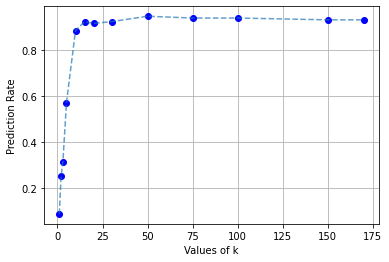

In [9]:
plt.plot(ks,prediction_rate,"bo")
plt.plot(ks,prediction_rate,alpha=0.7,linestyle='dashed')
#plt.axis([0, 1, 0, 200]) # range of x and y axis
plt.ylabel('Prediction Rate')
plt.xlabel('Values of k')
plt.grid()
plt.show()

In [10]:
#alpha_test_padded = np.pad(alpha_test.T[counter][0:k],(0,alpha.shape[1]-k),"constant",constant_values=(0,0))
#print(alpha_test_padded)
print(np.sum(np.square(alpha_test.T[counter]-alpha.T[counter])))

736.1785403498792


In [11]:
# SVD 
print(train_image_array_mean.shape)
U,sigma,V_T = np.linalg.svd(train_image_array_mean.T,full_matrices=False)
print(U.shape)

(192, 10304)
(10304, 192)


In [12]:
_,c = U.shape
for i in range(c):
    U[:,i] = U[:,i]/(np.sqrt(np.sum(np.square(U[:,i]))))

In [13]:
#print(np.matmul(U,U.T))
alpha_svd =np.matmul(U.T,train_image_array_mean.T)
print("Shape of alpha ",alpha_svd.shape)
alpha_1_svd = alpha_svd.T[0]

Shape of alpha  (192, 192)


In [14]:
alpha_svd_test = np.matmul(U.T,test_image_array_mean.T)
print("alpha_test shape ",alpha_svd_test.shape)

alpha_test shape  (192, 128)


In [15]:
ks = [1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100, 150, 170]
prediction_rate = [] #for each k

#pick one group from the test set and compare each element of it with the other group
for k in ks:
    correct_prediction_count = 0
    for counter, ele in enumerate(alpha_test.T):
        temp_diff_alphas = []
        for i, a in enumerate(alpha.T):
            alpha_test_padded = np.pad(alpha_test.T[counter][0:k],(0,alpha.shape[1]-k),"constant",constant_values=(0,0))
            temp_diff_alphas.append(np.sum( np.square(alpha.T[i] - alpha_test_padded )))
        index = np.argmin(temp_diff_alphas)
        if (counter//4 == index//6):
            correct_prediction_count += 1
    prediction_rate.append(correct_prediction_count/float(test_image_array_mean.shape[0]))

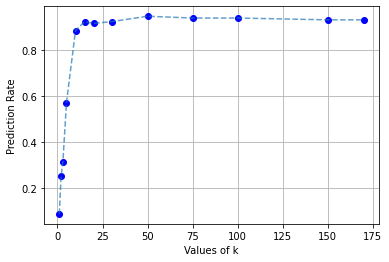

In [16]:
plt.plot(ks,prediction_rate,"bo")
plt.plot(ks,prediction_rate,alpha=0.7,linestyle='dashed')
#plt.axis([0, 1, 0, 200]) # range of x and y axis
plt.ylabel('Prediction Rate')
plt.xlabel('Values of k')
plt.grid()
plt.show()

In [17]:
YALE_PATH = "../../CroppedYale"
train_image_array = []
train_image_labels = []
test_image_array = []
test_image_labels = []
mean_image = []

def im2double(im):
    min_val = np.min(im)
    max_val = np.max(im)
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

folder_list = os.listdir(YALE_PATH)
for i in folder_list:
    folder_path = os.path.join(YALE_PATH,i)
    files = os.listdir(folder_path)
    for j in files[:40]:
        filepath = os.path.join(folder_path,j)
        im = cv2.imread(filepath,0)
        train_image_array.append(im2double(im).ravel())
        train_image_labels.append(i[-2:])
        
train_image_array = np.array(train_image_array)
print(train_image_array.shape)

for i in folder_list:
    folder_path = os.path.join(YALE_PATH,i)
    files = os.listdir(folder_path)
    for j in files[40:]:
        filepath = os.path.join(folder_path,j)
        im = cv2.imread(filepath,0)
        test_image_array.append(im2double(im).ravel())
        test_image_labels.append(i[-2:])
        
test_image_array = np.array(test_image_array)
print(test_image_array.shape)       

(1520, 32256)
(895, 32256)


In [18]:
train_mean = np.zeros(train_image_array.shape[1])
for i in range(train_image_array.shape[0]):
    train_mean = train_mean + train_image_array[i,:]

train_mean = train_mean*1.0/train_image_array.shape[0]
train_image_array_mean = train_image_array - train_mean

U,sigma,V_T = np.linalg.svd(train_image_array_mean.T,full_matrices=False)
_,c = U.shape
for i in range(c):
    U[:,i] = U[:,i]/(np.sqrt(np.sum(np.square(U[:,i]))))
    
alpha =np.matmul(U.T,train_image_array_mean.T)
print("Shape of alpha ",alpha.shape)

test_image_array_mean = test_image_array - train_mean
alpha_test = np.matmul(U.T,test_image_array_mean.T)
print("alpha_test shape ",alpha_test.shape)

Shape of alpha  (1520, 1520)
alpha_test shape  (1520, 895)


In [19]:
# Project each image on eigen-space and find the closest image in terms of minimum squared difference of alpha_test and other alphas.

ks = [1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100, 200, 300, 500, 1000]
prediction_rate = [] #for each k

#pick one group from the test set and compare each element of it with the other group
for k in tqdm(ks,desc="k values"):
    correct_prediction_count = 0
    for counter, ele in enumerate(alpha_test.T):
        index = np.argmin(np.sum(np.square((alpha.T[:,3:3+k]-alpha_test.T[counter,3:3+k])),axis=1))
        if (counter//24 == index//40):
            correct_prediction_count += 1
    prediction_rate.append(correct_prediction_count/float(test_image_array_mean.shape[0]))

k values: 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


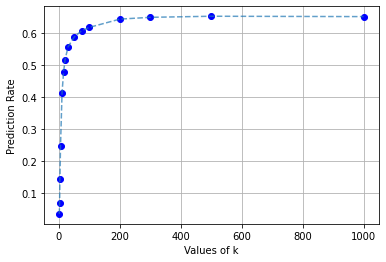

In [20]:
plt.plot(ks,prediction_rate,"bo")
plt.plot(ks,prediction_rate,alpha=0.7,linestyle='dashed')
#plt.axis([0, 1, 0, 200]) # range of x and y axis
plt.ylabel('Prediction Rate')
plt.xlabel('Values of k')
plt.grid()
plt.show()

In [21]:
ORL_PATH = "../../ORL"
train_image_array = []
train_image_labels = []
test_image_array = []
test_image_labels = []
mean_image = []

def im2double(im):
    min_val = np.min(im)
    max_val = np.max(im)
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

for i in range(1,33):
    folder_path = os.path.join(ORL_PATH,"s"+str(i))
    for j in range(1,7):
        filepath = os.path.join(folder_path,str(j)+".pgm")
        im = cv2.imread(filepath,0)
        train_image_array.append(im2double(im).ravel())
        train_image_labels.append("s"+str(i))
        
train_image_array = np.array(train_image_array)
print(train_image_array.shape)

# for i in range(1,33):
#     folder_path = os.path.join(ORL_PATH,"s"+str(i))
#     for j in range(7,11):
#         filepath = os.path.join(folder_path,str(j)+".pgm")
#         im = cv2.imread(filepath,0)
#         test_image_array.append(im2double(im).ravel())
#         test_image_labels.append("s"+str(i))
        
# test_image_array = np.array(test_image_array)
# print(test_image_array.shape)       

(192, 10304)


In [22]:
#train_mean = np.mean(train_image_array,axis=0)
train_mean = np.zeros(train_image_array.shape[1])
for i in range(train_image_array.shape[0]):
    train_mean = train_mean + train_image_array[i,:]

train_mean = train_mean*1.0/train_image_array.shape[0]
    
#print(train_mean.shape)
train_image_array_mean = train_image_array - train_mean
#print(train_image_array_mean+train_mean == train_image_array)

L_train = np.matmul(train_image_array_mean,train_image_array_mean.T)
print(L_train.shape)

(192, 192)


In [23]:
eig_val,W = np.linalg.eig(L_train)
print(W.shape)
print(eig_val.shape)

(192, 192)
(192,)


In [24]:
V = np.matmul(train_image_array_mean.T,W)
_,c = V.shape
for i in range(c):
    V[:,i] = V[:,i]/(np.sqrt(np.sum(np.square(V[:,i]))))

print(V.shape)
#print(np.linalg.norm(V[:,2]))

(10304, 192)


In [25]:
alpha = np.dot(V.T,train_image_array_mean.T)
print("Shape of alpha ",alpha.shape)
alpha_1 = alpha.T[0]
#print(alpha_1)

Shape of alpha  (192, 192)


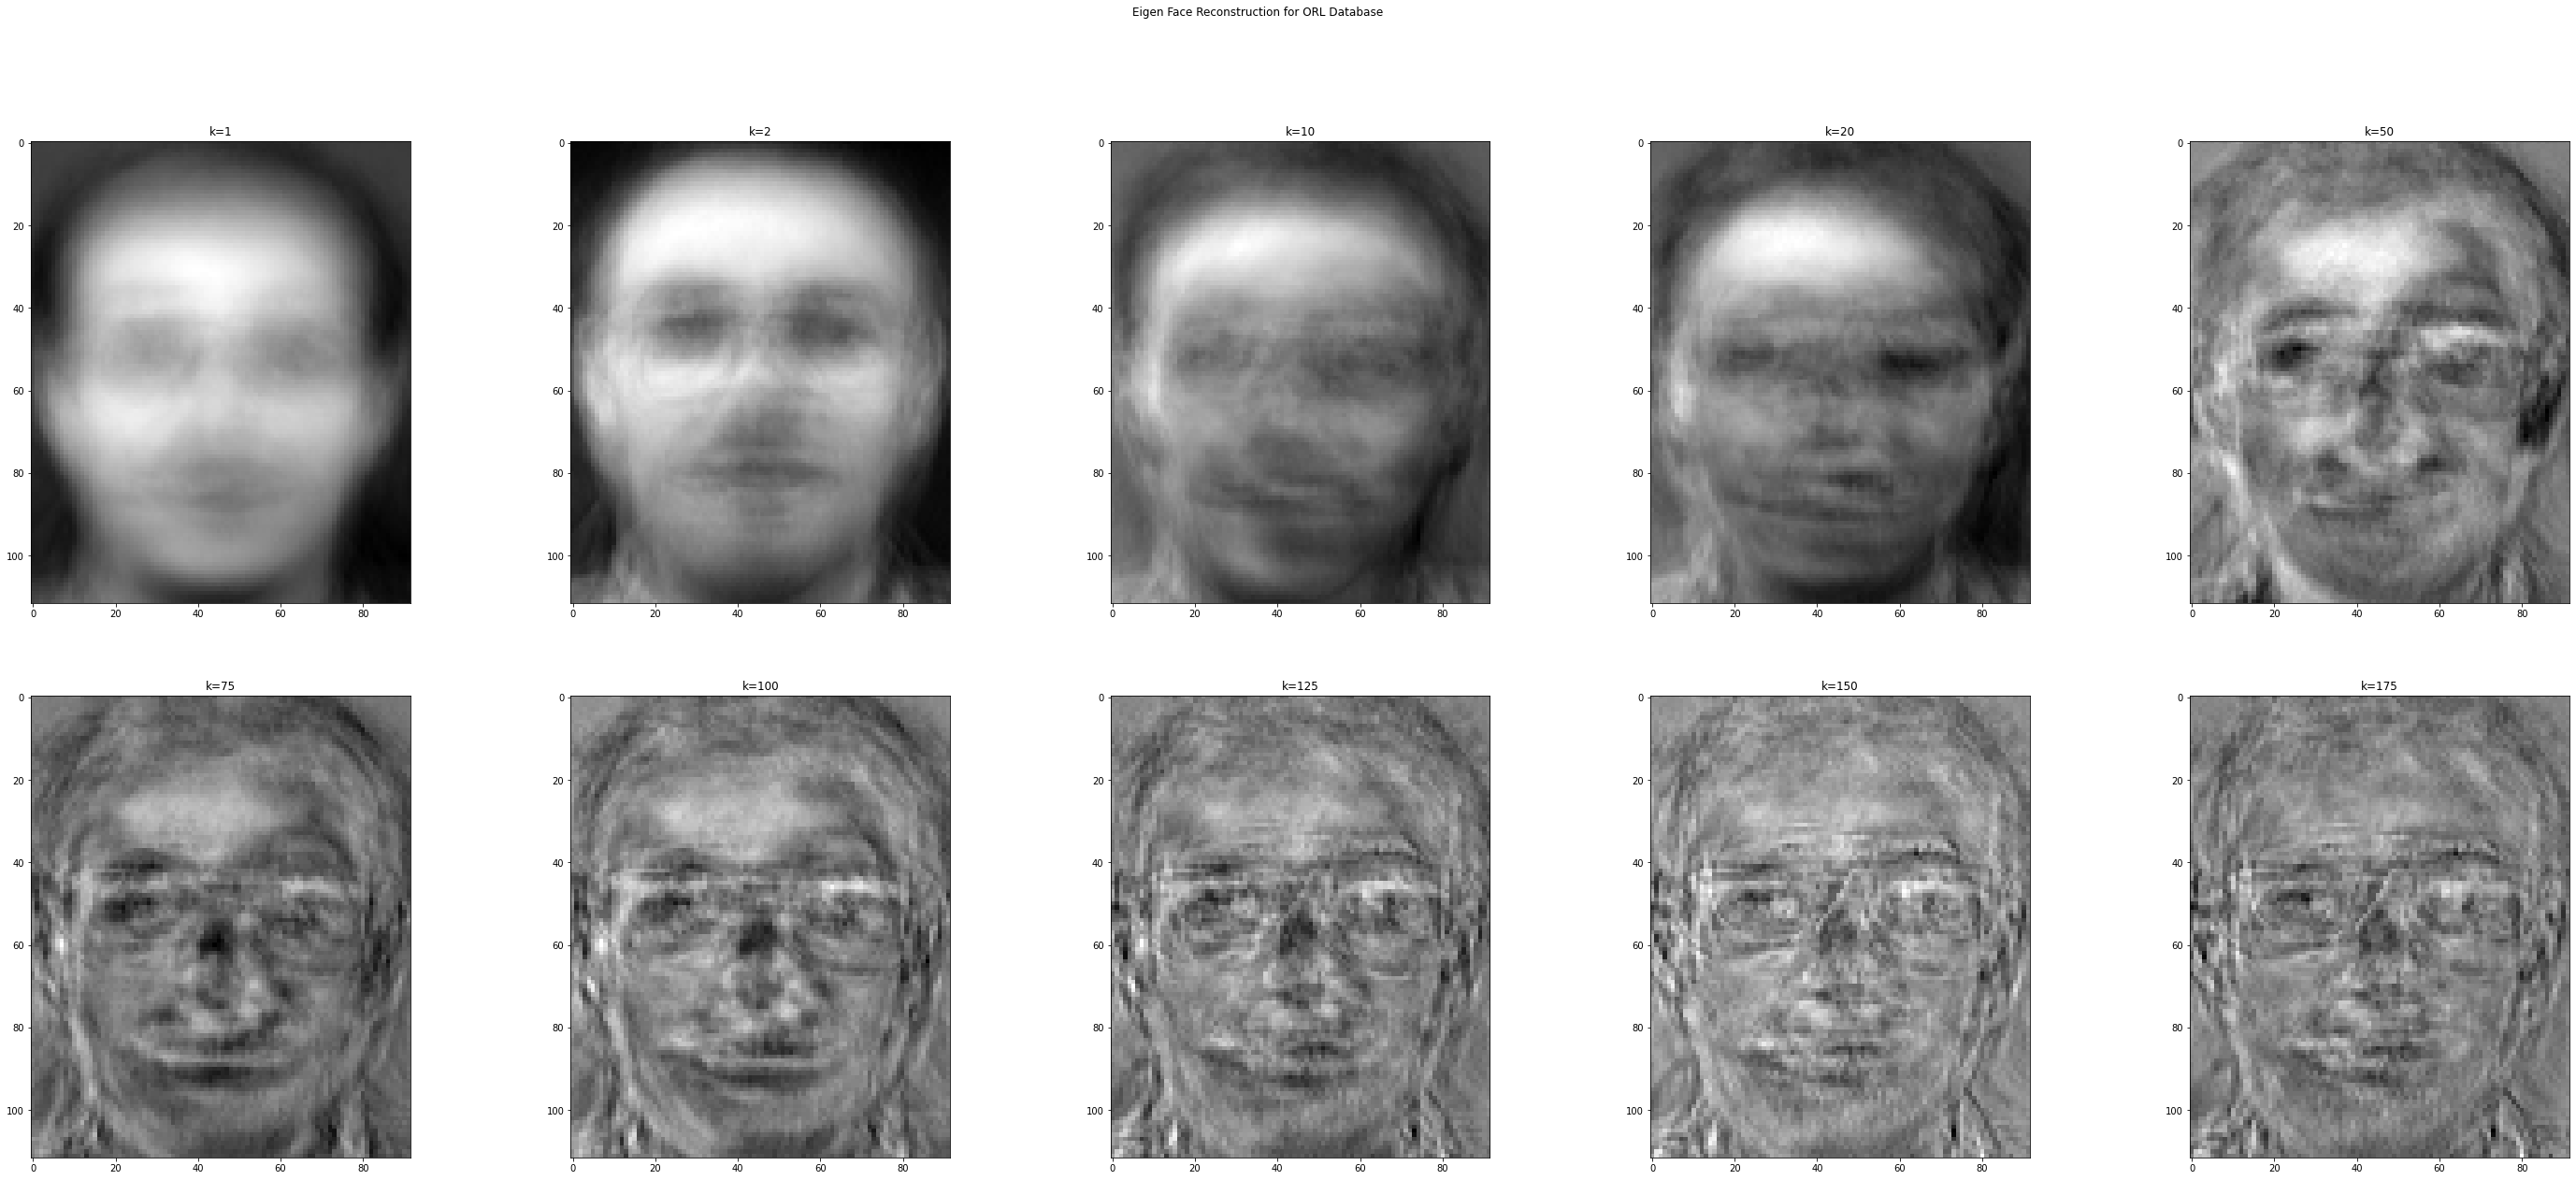

In [26]:
# test_image_array_mean = test_image_array - train_mean
# alpha_test = np.matmul(V.T,test_image_array_mean.T)
# print("alpha_test shape ",alpha_test.shape)

# Project each image on eigen-space and find the closest image in terms of minimum squared difference of alpha_test and other alphas.
ks = [1, 2, 10, 20, 50, 75, 100, 125, 150, 175]
# prediction_rate = [] #for each k
num_plots= len(ks)
#pick one group from the test set and compare each element of it with the other group
plt.figure(figsize=(50,20))
plt.suptitle("Eigen Face Reconstruction for ORL Database")
for k in range(num_plots):
    reconstructed = []
    for i in range(ks[k]):
        reconstructed.append(alpha[0,i]*V[:,i])
    reconstructed = np.array(reconstructed)
    reconstructed = np.sum(reconstructed,axis=0) + train_mean
    plt.subplot(2,5,k+1)
    plt.title("k={}".format(ks[k]))
    plt.imshow(reconstructed.reshape(112,92),cmap="gray")
    
    
    
    

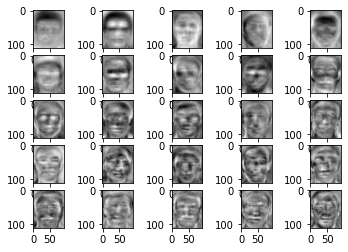

In [27]:
plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(V[:,i].reshape(112,92),cmap="gray")
    

In [28]:
ORL_PATH = "../../ORL"
train_image_array = []
train_image_labels = []
test_image_array = []
test_image_labels = []
mean_image = []

def im2double(im):
    min_val = np.min(im)
    max_val = np.max(im)
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

for i in range(1,33):
    folder_path = os.path.join(ORL_PATH,"s"+str(i))
    for j in range(1,7):
        filepath = os.path.join(folder_path,str(j)+".pgm")
        im = cv2.imread(filepath,0)
        train_image_array.append(im2double(im).ravel())
        train_image_labels.append("s"+str(i))
        
train_image_array = np.array(train_image_array)
print(train_image_array.shape)

(192, 10304)


In [29]:
def shiftLbyn(arr, n=0):
    return arr[n::] + arr[:n:]

def calculate_mean(array):
    mean = np.mean(array,axis=0)
    return mean

def normalize_vector(U):
    _,c = U.shape
    for i in range(c):
        U[:,i] = U[:,i]/(np.sqrt(np.sum(np.square(U[:,i]))))
    return U

def cross_validate(array,num):
    r,_ = array.shape
    error = np.zeros(r//num)
    for i in range(0,r,num):
        max_error = 0
        squared_error = 0
        for j in range(6):
            indices = shiftLbyn(list(range(6)),j)
            train_indices = indices[:-1]
            test_index = indices[-1]
            
            train_images = []
            for k in train_indices:
                train_images.append(array[i+k,:])
            train_images = np.array(train_images)
            mean = calculate_mean(train_images)
            train_images = train_images - mean
            test_image = np.array(array[i+test_index,:])
            test_image = test_image - mean
            
            # SVD 
            U,sigma,V_T = np.linalg.svd(train_images.T,full_matrices=False)
            #print(U.shape)
            U = normalize_vector(U)
            
            alpha_svd =np.matmul(U.T,train_images.T)
            #print("Shape of alpha ",alpha_svd.shape)
            alpha_svd_test = np.matmul(U.T,test_image.T)
            #print("Shape of alpha_test ",alpha_svd_test.shape)
            
            
            squared_error += np.sum(np.square(alpha_svd[:,3:]- alpha_svd_test[3:]))
#             if squared_error>max_error:
#                 max_error = squared_error
        
        error[i//num] = squared_error/6
        # error[i//num] = max_error
        
    return error

threshold_error = cross_validate(train_image_array,6)
print(threshold_error)

[420.16594119 155.16556196 338.27942851 355.09878377 212.31180518
 212.64060808 181.1335819  231.25717454 250.39597435 351.90837891
 300.47077459 266.3178153  243.02613579 214.87461302 203.61973194
 376.49880071 274.39294014 238.92563805 229.84348023 300.14482959
 201.54857925 160.39224089 272.79681106 216.81040782 249.70220533
 242.6429657  270.16812666 321.36874086 249.34334076 180.16837955
 380.92626882 296.39101167]


In [30]:
ORL_PATH = "../../ORL"
train_image_array_last = []
train_image_labels_last = []

def im2double(im):
    min_val = np.min(im)
    max_val = np.max(im)
    out = (im.astype('float') - min_val) / (max_val - min_val)
    return out

for i in range(1,33):
    folder_path = os.path.join(ORL_PATH,"s"+str(i))
    for j in range(1,7):
        filepath = os.path.join(folder_path,str(j)+".pgm")
        im = cv2.imread(filepath,0)
        train_image_array_last.append(im2double(im).ravel())
        train_image_labels_last.append("s"+str(i))
        
train_image_array_last = np.array(train_image_array_last)
print(train_image_array_last.shape)

test_image_array_last = []
test_image_labels_last = []


for i in range(1,33):
    folder_path = os.path.join(ORL_PATH,"s"+str(i))
    for j in range(7,11):
        filepath = os.path.join(folder_path,str(j)+".pgm")
        im = cv2.imread(filepath,0)
        test_image_array_last.append(im2double(im).ravel())
        test_image_labels_last.append("s"+str(i))
        
for i in range(33,41):
    folder_path = os.path.join(ORL_PATH,"s"+str(i))
    for j in range(1,11):
        filepath = os.path.join(folder_path,str(j)+".pgm")
        im = cv2.imread(filepath,0)
        test_image_array_last.append(im2double(im).ravel())
        test_image_labels_last.append("s"+str(i))

        
test_image_array_last = np.array(test_image_array_last)
print(test_image_array_last.shape)

(192, 10304)
(208, 10304)


In [31]:
def calculate_mean(array):
    mean = np.mean(array,axis=0)
    return mean

train_mean_last = calculate_mean(train_image_array_last)
train_image_array_mean_last = train_image_array_last - train_mean_last
test_image_array_mean_last = test_image_array_last - train_mean_last

In [32]:
U_last,sigma_last,V_T_last = np.linalg.svd(train_image_array_mean_last.T,full_matrices=False)
print(U_last.shape)
_,c = U_last.shape
for i in range(c):
    U_last[:,i] = U_last[:,i]/(np.sqrt(np.sum(np.square(U_last[:,i]))))

(10304, 192)


In [33]:
alpha_svd_last =np.matmul(U_last.T,train_image_array_mean_last.T)
alpha_svd_test_last = np.matmul(U_last.T,test_image_array_mean_last.T)
print(alpha_svd_last.shape)
print(alpha_svd_test_last.shape)

(192, 192)
(192, 208)


In [34]:
#ks_last = [1, 2, 3, 5, 10, 15, 20, 30, 50, 75, 100, 150, 170,192]
# prediction_rate_last = []
false_positive = 0
true_positive = 0
false_negative = 0
true_negative = 0

# records = {"k": [],"false_positive": [],"true_negative": []}

#for k in tqdm(ks_last,desc="k values"):
# false_positive = 0
# true_positive = 0
# false_negative = 0
# true_negative = 0
# correct_prediction_count = 0
for counter, ele in enumerate(alpha_svd_test_last.T):
    errors = np.sum(np.square(alpha_svd_last.T[:,3:]-alpha_svd_test_last.T[counter][3:alpha_svd_last.shape[0]]),axis=1)
    index = np.argmin(errors)
    if counter//4<=31:
        if counter//4 != index//6:
            false_negative += 1
        elif counter//4 == index//6:
            true_positive += 1
    else:
        if errors[index] <= threshold_error[index//6]:
            false_positive += 1
        else:
            true_negative += 1
# records["k"].append(k)
# records["false_positive"].append(false_positive)
# records["true_negative"].append(true_negative)


print("FP : {} :: FN : {} :: TP : {} :: TN : {}".format(false_positive,false_negative,true_positive,true_negative))
#print(records)

FP : 58 :: FN : 15 :: TP : 113 :: TN : 22


In [35]:
print(threshold_error[24//6])
print(errors[24])

212.31180517764506
114.0299615230503
